# Using Sensitivity Analysis on Discovery Cluster
using Array Jobs to Interrogate Models

Original Sensitivity Analysis notebook: Will Usher, UCL Energy Institute, 10th December 2015 <br/>
Updates to demonstrate running array jobs on a cluster: Richard West, 2016

In this version, most of the background and detail have been removed. Please refer to the original at https://github.com/SALib/SATut if you are not familiar with the system.

In [1]:
from ipywidgets import widgets, interact
from IPython.display import display
%matplotlib inline
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
figsize(12, 10)
sbn.set_context("talk", font_scale=1)

# The model used for this seminar is contained in the file model.py
from model import cost_of_vehicle_to_grid, compute_profit, annualized_capital_cost, battery_lifetime, max_vehicle_power

In [2]:
# Uncomment and execute the following line to see the contents of the `model.py` file
# %load model.py

## Using SALib to run a Sensitivity Analysis

As we saw earlier, SALib is a **free** **open-source** **Python** library which you can install by running the command

```python
pip install SALib
```

[Documentation](http://salib.readthedocs.org/) is available online.


### Import the package

In [3]:
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp

### Define a problem file

In the code below, a problem file is used to define the variables we wish to explore.

In the script we run on Discovery, it's important that the names here match the parameter names to the function that we're evaluating, i.e. `max_vehicle_power()` in the `model.py` file.

In [4]:
morris_problem = {
    # There are six variables
    'num_vars': 7,
    # These are their names
    'names': ['connector_power', 'stored_energy', 'distance_driven', 'range_buffer', 'driving_efficiency', 'inverter_efficiency', 'dispatch_time'],
    # These are their plausible ranges over which we'll move the variables
    'bounds': [[2.3, 22], # connection_power (kW)
               [50, 100], # battery size (kWh)
               [0, 80], # distance driven (km)
               [0, 80], # range buffer (km)
               [4,5.5], # driving efficiency (kWh/km)
               [0.87,0.97], # inverter efficienct (%)
               [0.5, 24] # dispatch time - hours of the day in which the energy is dispatched
              ],
    # I don't want to group any of these variables together
    'groups': None
    }

### Generate a Sample

We then generate a sample using the `morris.sample()` procedure from the SALib package.

In [5]:
number_of_trajectories = 1000
sample = ms.sample(morris_problem, number_of_trajectories, num_levels=4, grid_jump=2)
print("The sample array is ",sample.shape)
print("Here are the first 10 rows:")
for j in range(10):
    print(' '.join(['{:10.3f}'.format(i) for i in sample[j]]))


The sample array is  (8000, 7)
Here are the first 10 rows:
    15.433    100.000     53.333     80.000      4.000      0.870     24.000
    15.433    100.000      0.000     80.000      4.000      0.870     24.000
     2.300    100.000      0.000     80.000      4.000      0.870     24.000
     2.300    100.000      0.000     26.667      4.000      0.870     24.000
     2.300     66.667      0.000     26.667      4.000      0.870     24.000
     2.300     66.667      0.000     26.667      4.000      0.937     24.000
     2.300     66.667      0.000     26.667      4.000      0.937      8.333
     2.300     66.667      0.000     26.667      5.000      0.937      8.333
    15.433     50.000      0.000     80.000      4.500      0.937     24.000
    15.433     50.000      0.000     26.667      4.500      0.937     24.000


Now we're going to save the parameters to a file, so we can run the jobs separately not in this notebook.
Because the parameters in the sensitivity analysis problem may not be (in fact *are not*!) in the same order as those expected by the function (this took me a while to notice) we save the column orders into the parameters file as a header.

In [6]:
header = ' '.join(morris_problem['names'])
np.savetxt("parameter_values.txt", sample, header=header)


# Stop!  
## Now (pretend) we need to run the simulations on Discovery

To run this on Discovery, you will need to copy the `parameter_values.txt` file on to Discovery, along with a Python script file (eg. `script.py`) that looks like the cell a few lines below.  Use an SCP or SFTP program, as described earlier in the tutorial.

This is how many simulations we will need to run:

In [7]:
len(sample)

8000

...but the Slurm on Discovery is configured with a maximum job array size of 1001. (Run `scontrol show config | grep MaxArraySize` on Discovery to check). So we will run 1000 jobs, each of which runs 8 simulations.  (In real life, split into as few jobs as reasonable, to avoid clogging Slurm with thousands of needless jobs. i.e. 100 jobs each of 80 simulations would be better, or even 10 jobs of 800).

First, some tips and tricks that will help you write your own `script.py` (or understand mine). Be sure you understand each of these cells in isolation before putting them together

In [15]:
header = open("parameter_values.txt").readline() # open the file and read the first line
print(header)
header = header.strip('#\n ') # remove the '#', space, and newline from the start and end
column_names = header.split() # split on whitespace, to get a list
column_names

# connector_power stored_energy distance_driven range_buffer driving_efficiency inverter_efficiency dispatch_time



['connector_power',
 'stored_energy',
 'distance_driven',
 'range_buffer',
 'driving_efficiency',
 'inverter_efficiency',
 'dispatch_time']

In [9]:
big_parameter_list = np.loadtxt("parameter_values.txt")
parameters = big_parameter_list[0]
parameters

array([  15.43333333,  100.        ,   53.33333333,   80.        ,
          4.        ,    0.87      ,   24.        ])

In [17]:
arguments_dictionary = { key:value for key, value in zip(column_names, parameters)}
arguments_dictionary

{'connector_power': 2.2999999999999998,
 'dispatch_time': 16.166666666666664,
 'distance_driven': 53.333333333333329,
 'driving_efficiency': 4.0,
 'inverter_efficiency': 0.93666666666666665,
 'range_buffer': 0.0,
 'stored_energy': 83.333333333333329}

In [18]:
max_vehicle_power(**arguments_dictionary)

2.2999999999999998

See [here](https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists)
for how this unpacking of argument dictionaries works (the meaning of the `**`)

*The following cell contains the script.py. To update it uncomment the first `%load script.py` line and execute it - that will load in the `script.py` file which lives alongside this notebook and is where you should make changes if you are editing this tutorial.*

In [ ]:
%load script.py
# This is a script that you should run on Discovery,
# as part of a Slurm Array job, with 1000 jobs.
import numpy as np
import os
from model import max_vehicle_power
big_parameter_list = np.loadtxt("parameter_values.txt")
header = open("parameter_values.txt").readline()
header = header.strip('#\n ') # remove the '#', space, and newline from the start and end
column_names = header.split()

job_number = int(os.getenv('SLURM_ARRAY_TASK_ID', default='0'))
assert 0<=job_number<1000, "Job number should run from 0 to 999"
for i in range(8):
    parameter_number = (8 * job_number) + i
    parameters = big_parameter_list[parameter_number]
    arguments_dictionary = { key:value for key, value in zip(column_names, parameters)}
    result = max_vehicle_power(**arguments_dictionary)
    """
    Because we don't know what order the jobs will complete in,
    the results may be written out of order!
    To deal with this, we will write the job number in the results file
    as well as the result:
    """
    with open("results.txt", 'a') as result_file: # 'a' is append mode, and will add to the file.
        result_file.write('{} {}\n'.format(parameter_number, result)) # the '\n' is a new line


Then create a `submit.sh` script to run it as an Array job, to fill the `results.txt` file with results.
But realize that your Python script above expects the job number to start at zero, so you'll probably want something like
```
#SBATCH --array=0-999%40
```
in your submit file. eg. your `submit.sh` may look something like this:

```
#!/bin/sh
#SBATCH -n 1
#SBATCH -N 1
#SBATCH --job-name=SA
#SBATCH --array=0-999
#SBATCH -p ser-par-10g
python3 script.py
```

Once your jobs have all finished, copy the `results.txt` back to your computer and put it alongside this Notebook. Hopefully we can import it like this:

In [ ]:
np.loadtxt("results.txt")

In an ideal world, that would have worked. But computers aren't ideal, and it probably didn't. Open the `results.txt` file in a text editor and take a look at it carefully. My results file starts out looking OK:

```
0 2.416666666666667
1 2.9
2 2.3
3 2.3
4 2.175
8 1.2575617283950618
5 2.3
9 1.7201131687242797
```

but there are some blank lines:

```
87 5.127272727272728
64 2.509259259259259
65 3.763888888888889

73 15.433333333333334
74 1.5426804123711344
68 3.257828282828283
```

and occasionally really weird things:

```
70 9.382545454545456
77 2.3
78 2.3
088888888889
79 2.3
56 4.697333333333334
```

The problem is (I think) that the different compute nodes running different processes all trying to write to the same file, which is stored on a networked file system on yet another computer, are conflicting, instead of waiting their turn to write to the file. This is notoriously difficult to manage, as there are all sorts of levels of cacheing involved. 

What we'll try next is to split the 8000 jobs into 100 jobs each running 80 parameter sets, and have each job print the results into its standard output file, which Slurm will collect into 100 separate files. Then we'll concatenate the 100 output files when the jobs are all done.

In [ ]:
%load script2.py
# This is a script that you should run on Discovery,
# as part of a Slurm Array job, with 100 jobs.
import numpy as np
import os
from model import max_vehicle_power
big_parameter_list = np.loadtxt("parameter_values.txt")
header = open("parameter_values.txt").readline()
header = header.strip('#\n ') # remove the '#', space, and newline from the start and end
column_names = header.split()

job_number = int(os.getenv('SLURM_ARRAY_TASK_ID', default='0'))
assert 0<=job_number<100, "Job number should run from 0 to 99"
for i in range(80):
    parameter_number = (80 * job_number) + i
    parameters = big_parameter_list[parameter_number]
    arguments_dictionary = { key:value for key, value in zip(column_names, parameters)}
    result = max_vehicle_power(**arguments_dictionary)
    print('{} {}'.format(parameter_number, result))


If you run a batch job like this:

```
#!/bin/sh
#SBATCH -n 1
#SBATCH -N 1
#SBATCH --job-name=SA
#SBATCH --array=0-99
#SBATCH -p ser-par-10g
#SBATCH -e error_%a.log
#SBATCH -o output_%a.log
stdbuf -o0 -e0 python3 -u script2.py
```

Then you have run it on Discovery you should have 100 files named `output_0.log` etc. (and 100 named `error_0.log` which are hopefully empty).  Concatenate them all the error files to the screen to check they're empty, then concatenate all the output files into a `results.txt` file:
```
$ cat error*.log
$ cat output*.log > results.txt
```
then copy the results.txt file back to your computer and put it alongside this notebook.

## Importing and analyzing the results 
Then come back here to load the results and continue the sensitivy analysis.
Because our results file may not be in order, but contains the job number at the start of each line, we need to do a little manipulation to get the `output` array as needed by SALib

In [19]:
results_array = np.loadtxt("results.txt")
print(results_array[:5,])
results_dict = dict()
for number, value in results_array:
    i = int(number)
    assert i not in results_dict, "Duplicate entry! {}".format(i)
    results_dict[i] = value
output = np.array([results_dict[i] for i in range(len(results_dict))])
print(output[:5])

[[ 0.          2.41666667]
 [ 1.          2.9       ]
 [ 2.          2.3       ]
 [ 3.          2.3       ]
 [ 4.          2.175     ]]
[ 2.41666667  2.9         2.3         2.3         2.175     ]


We will re-load the sample array from the input file, in case the one in memory changed.
 Ensure the `parameter_values.txt` is the same file you had on Discovery 
 when you generated the results.txt.
Because the sample is based on random numbers, it changes every time you run the notebook cell above  to generate it, and your results will be completely wrong if you use the wrong sample to analyze the output!

In [20]:
sample = np.loadtxt("parameter_values.txt")
sample

array([[  15.43333333,  100.        ,   53.33333333, ...,    4.        ,
           0.87      ,   24.        ],
       [  15.43333333,  100.        ,    0.        , ...,    4.        ,
           0.87      ,   24.        ],
       [   2.3       ,  100.        ,    0.        , ...,    4.        ,
           0.87      ,   24.        ],
       ..., 
       [  15.43333333,  100.        ,   80.        , ...,    5.        ,
           0.97      ,    0.5       ],
       [  15.43333333,  100.        ,   80.        , ...,    5.        ,
           0.97      ,   16.16666667],
       [  15.43333333,  100.        ,   80.        , ...,    4.        ,
           0.97      ,   16.16666667]])

### Factor Prioritisation

We'll run a sensitivity analysis to see which is the most influential parameter.

The results parameters are called **mu**, **sigma** and **mu_star**.

* **Mu** is the mean effect caused by the input parameter being moved over its range.
* **Sigma** is the standard deviation of the mean effect.
* **Mu_star** is the mean absolute effect.

In [21]:
Si = ma.analyze(morris_problem, sample, output, print_to_console=False)
print("{:20s} {:>7s} {:>7s} {:>7s}".format("Name", "mu", "mu_star", "sigma"))
for name, s1, st, mean in zip(morris_problem['names'], Si['mu'], Si['mu_star'], Si['sigma']):
    print("{:20s} {:=7.2f} {:=7.2f} {:=7.2f}".format(name, s1, st, mean))

Name                      mu mu_star   sigma
connector_power         5.86    5.86    8.16
stored_energy           1.93    1.93    1.90
distance_driven      -  0.68    0.68    0.69
range_buffer         -  0.68    0.68    0.68
driving_efficiency      0.23    0.23    0.29
inverter_efficiency     0.23    0.23    0.27
dispatch_time        -  9.11    9.11    9.14


We can plot the results

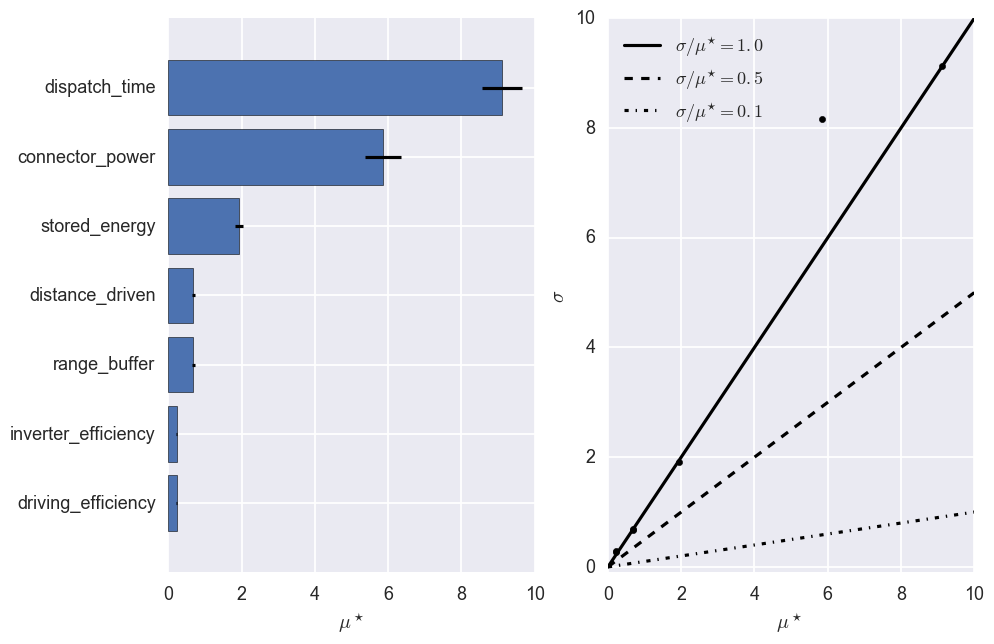

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2)
mp.horizontal_bar_plot(ax1, Si, param_dict={})
mp.covariance_plot(ax2, Si, {})

## Sanity check
Because this is such a trivially fast problem, we can do all 8000 simulations on laptop in a fraction of a second, so let's re-do it here in the notebook to compare with our results from above:

Name                      mu mu_star   sigma
connector_power         5.86    5.86    8.16
stored_energy           1.93    1.93    1.90
distance_driven      -  0.68    0.68    0.69
range_buffer         -  0.68    0.68    0.68
driving_efficiency      0.23    0.23    0.29
inverter_efficiency     0.23    0.23    0.27
dispatch_time        -  9.11    9.11    9.14


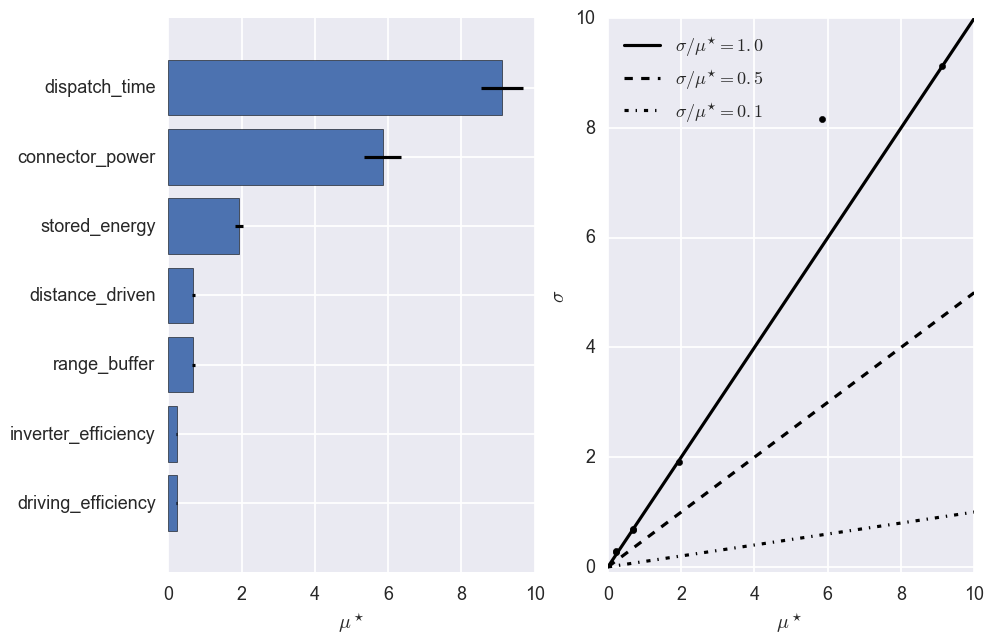

In [23]:
def monte_carlo_large(data):
    y = max_vehicle_power(data[0], data[1], data[2], data[3], data[6], data[4], data[5])
    return y
# Run the sample through the monte carlo procedure of the power model
output = monte_carlo_large(sample.T)
Si = ma.analyze(morris_problem, sample, output, print_to_console=False)
print("{:20s} {:>7s} {:>7s} {:>7s}".format("Name", "mu", "mu_star", "sigma"))
for name, s1, st, mean in zip(morris_problem['names'], Si['mu'], Si['mu_star'], Si['sigma']):
    print("{:20s} {:=7.2f} {:=7.2f} {:=7.2f}".format(name, s1, st, mean))
fig, (ax1, ax2) = plt.subplots(1,2)
mp.horizontal_bar_plot(ax1, Si, param_dict={})
mp.covariance_plot(ax2, Si, {})